In [35]:
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from scipy.stats import norm, binom
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
import dataset
import imgkit
import tools

%matplotlib inline
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]

In [38]:
def render_pd_styler(styler, filename):
    html = "<style type='text/css'>body{ background-color: transparent; }</style>" + styler.render()
    imgkit.from_string(html, filename)
    display(HTML(html))

    im = Image.open(filename)
    inv = ImageOps.invert(im.convert("RGB"))
    im = im.crop(inv.getbbox())
    im.save(filename, "PNG")


In [3]:
def plot_raw_ftr_distributions(b5, gender_age_income, mean_rt_per_cat, ratings):
    num_plots = 6
    fig, axs = plt.subplots(num_plots, figsize=(16, num_plots*8))
    fig.patch.set_facecolor("white")

    i = 0
    axs[i].set_title("B5 Distribution")
    axs[i].set_xlabel("Answer")
    axs[i].set_ylabel("Probability")
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i].hist(b5, bins=np.arange(-3,3)+0.5, density=True, label=list(f"Question {x}" for x in range(b5.shape[1])))
    axs[i].legend()
    i += 1

    axs[i].set_title("Gender Distribution")
    gender_sizes = [np.sum(gender_age_income[:,0] == 1), np.sum(gender_age_income[:,0] == 0)]
    gender_sizes.append(gender_age_income.shape[0]-sum(gender_sizes))
    axs[i].pie(gender_sizes, labels=["Female", "Male", "Non-Binary"], counterclock=False, autopct='%1.1f%%', startangle=90, explode=[0.01]*len(gender_sizes))
    axs[i].legend()
    i += 1

    axs[i].set_title("Age Distribution")
    axs[i].set_xlabel("Age")
    axs[i].set_ylabel("Probability Density")
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i].hist(gender_age_income[:,1], bins=np.arange(0, np.max(gender_age_income[:,1])+10, 5), density=True)
    i += 1


    axs[i].set_title("Income Distribution")
    axs[i].set_xlabel("Income Bracket")
    axs[i].set_ylabel("Probability")
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i].bar(*np.unique(gender_age_income[:,2], return_counts=True))
    i += 1

    axs[i].set_title("Mean Rating Per Category")
    axs[i].set_xlabel("Rating")
    axs[i].set_ylabel("Probability Density")
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i].hist(mean_rt_per_cat, bins=np.arange(1,6), density=True, label=list(f"Category {x}" for x in range(mean_rt_per_cat.shape[1])))
    axs[i].legend()
    i += 1

    
    axs[i].set_title("Ratings Distribution")

    val_split = 0.2
    n = int(np.prod(ratings.shape) * val_split)
    p = 0.05
    
    possible_ratings = np.arange(1,6)
    ratings_sizes = np.array([np.sum(ratings == i) for i in possible_ratings])
    ratings_probs = ratings_sizes/np.prod(ratings.shape)
    rand_acc = np.sum(np.square(ratings_probs))

    prob_mat = np.matmul(ratings_probs[:, np.newaxis], ratings_probs[np.newaxis, :])
    mae_mat = np.indices((*possible_ratings.shape, *possible_ratings.shape))
    mae_mat = np.abs(possible_ratings[mae_mat[0]] - possible_ratings[mae_mat[1]]) * prob_mat
    rand_mae = np.sum(mae_mat)
    rand_p = binom.ppf(1-p, n, rand_acc)/n

    mle_acc = np.max(ratings_probs)
    mle_mae = np.mean(np.abs(ratings-possible_ratings[np.argmax(ratings_probs)]))
    mle_p = binom.ppf(1-p, n, mle_acc)/n
    
    σ = np.std(ratings)

    axs[i].pie(ratings_sizes, labels=possible_ratings, autopct='%1.1f%%', counterclock=False, startangle=90, explode=[0.01]*len(ratings_sizes))
    axs[i].legend()
    axs[i].text(1.0, 1.1, f"MAE for dist. sampling={(rand_mae/σ):.2f}σ", fontsize=14)
    axs[i].text(1.0, 1.0, f"Accuracy for dist. sampling={(100*rand_acc):.2f}%", fontsize=14)
    axs[i].text(1.0, 0.9, f"Critical accuracy for dist. sampling={(100*rand_p):.2f}% (p={(p):.2f}, val={(100*val_split):.2f}%)", fontsize=14)

    axs[i].text(1.0, 0.7, f"MAE for MLE={(mle_mae/σ):.2f}σ", fontsize=14)
    axs[i].text(1.0, 0.6, f"Accuracy for MLE={(100*mle_acc):.2f}%", fontsize=14)
    axs[i].text(1.0, 0.5, f"Critical accuracy for MLE={(100*mle_p):.2f}% (p={(p):.2f}, val={(100*val_split):.2f}%)", fontsize=14)
    i += 1

    display(fig)
    plt.close()


Loaded user U0120/U0120


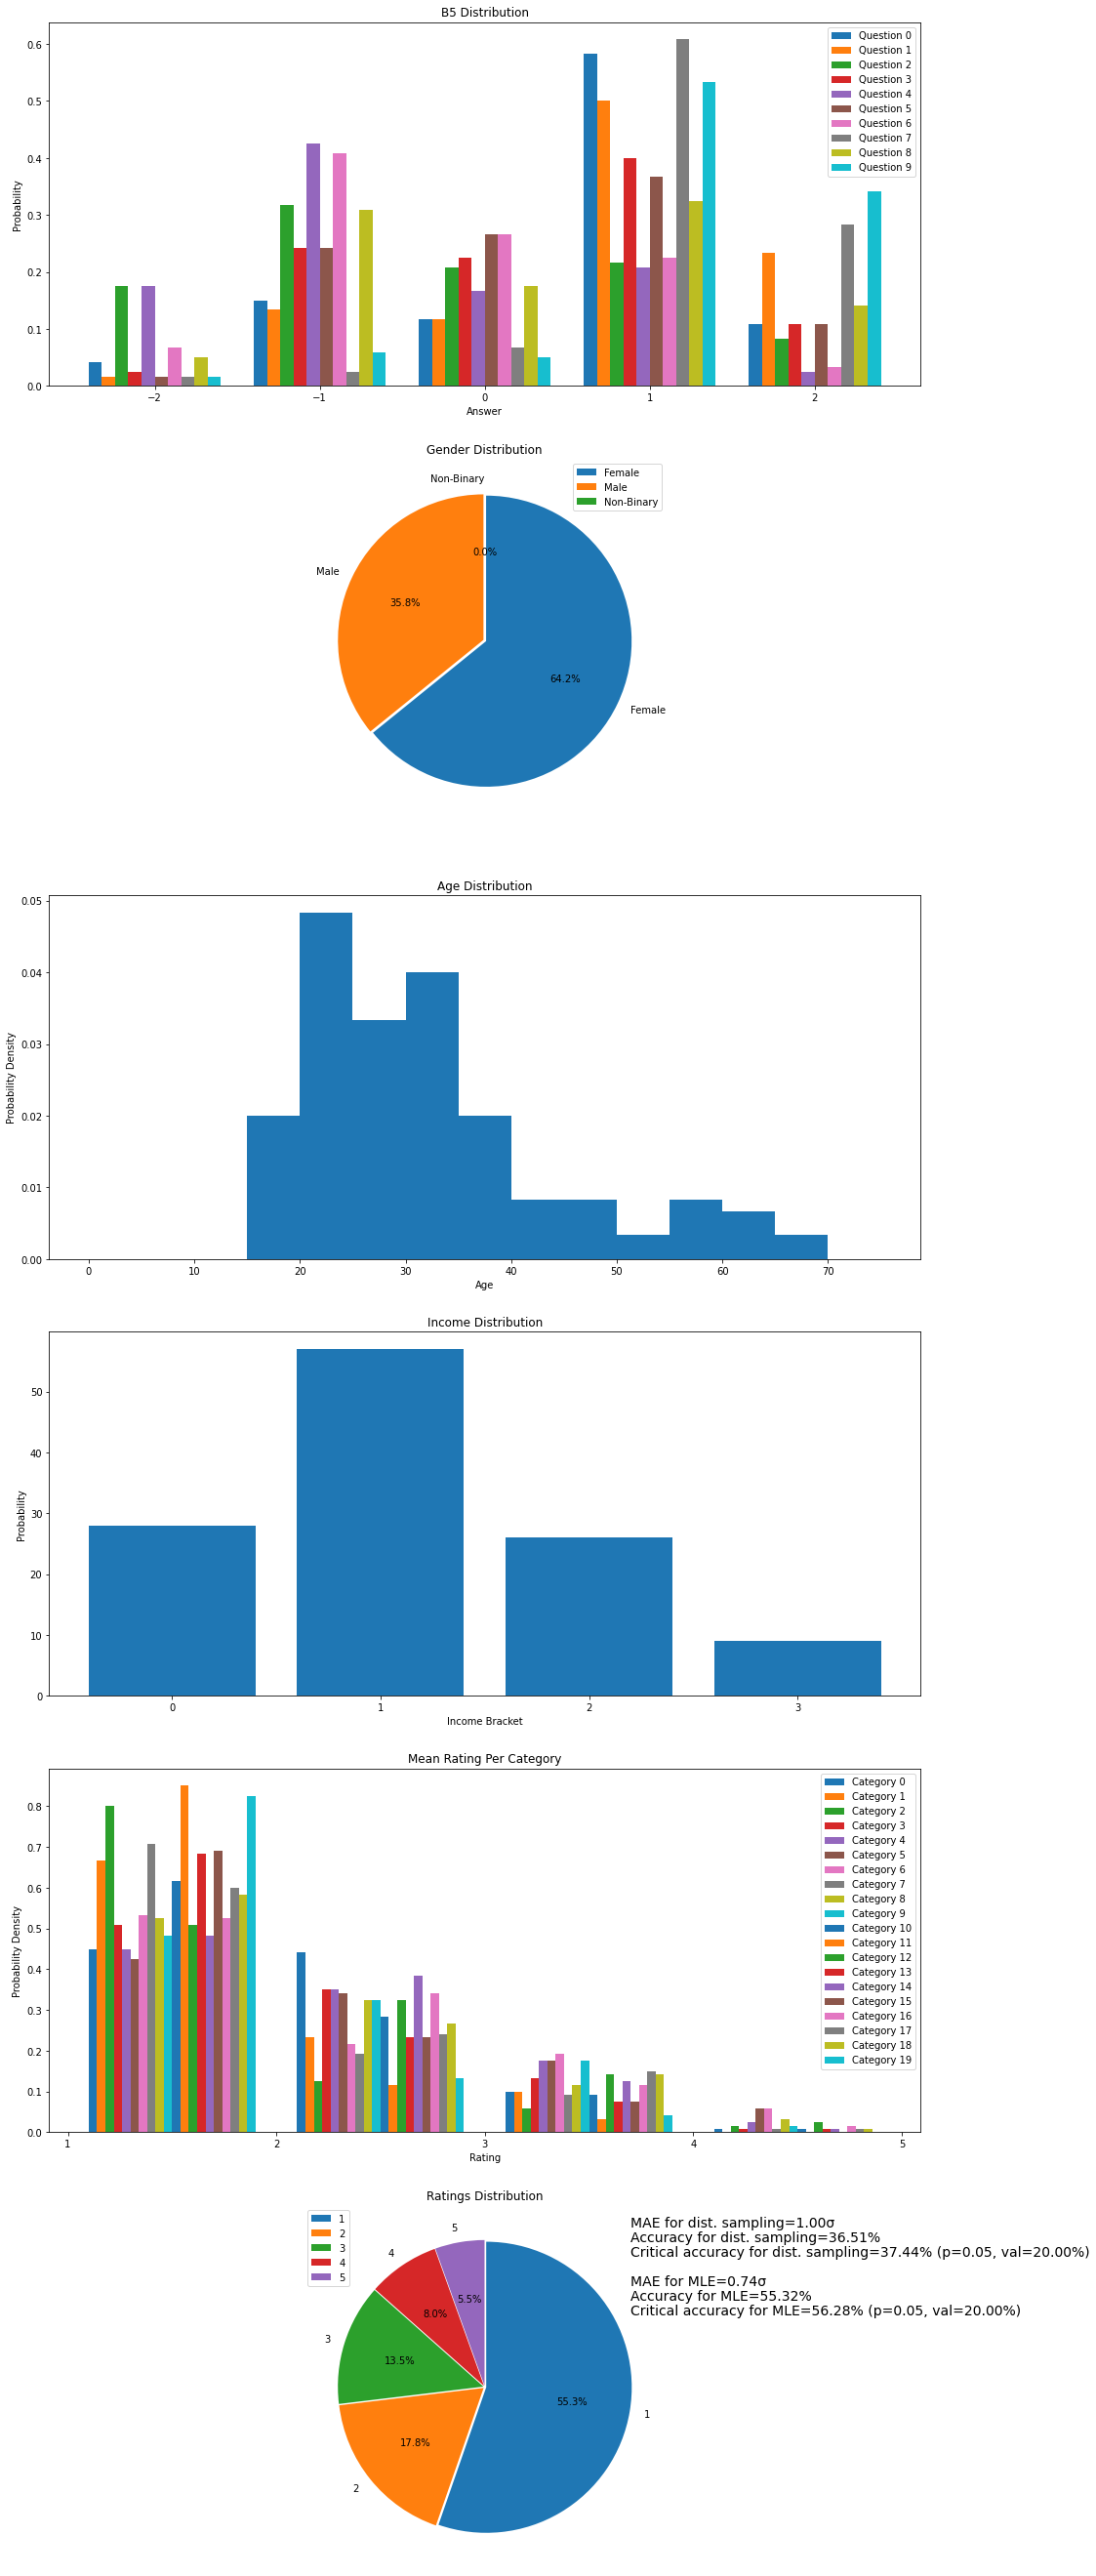

In [4]:
def load_raw_ftrs(root_directories, verbose=True, plot=False):
    b5_list = []
    gender_age_income_list = []
    mean_rt_per_cat_list = []
    ratings_list = []

    users = list(dataset.user_iterator(root_directories))
    last_user_id = users[-1][0]
    for (
        user_id,
        b5,
        gender_age_income,
        mean_rt_per_cat,
        ratings
    ) in users:
        b5_list.append(b5)
        gender_age_income_list.append(gender_age_income)
        mean_rt_per_cat_list.append(mean_rt_per_cat)
        ratings_list.append(ratings)
        if verbose:
            print(f"Loaded user {user_id}/{last_user_id}", end="\r")
    if verbose:
        print("")

    b5_list = np.array(b5_list)
    gender_age_income_list = np.array(gender_age_income_list)
    mean_rt_per_cat_list = np.array(mean_rt_per_cat_list)
    ratings_list = np.array(ratings_list)

    raw_ftrs = np.concatenate([b5_list, gender_age_income_list, mean_rt_per_cat_list], axis=-1)
    
    if plot:
        plot_raw_ftr_distributions(b5_list, gender_age_income_list, mean_rt_per_cat_list, ratings_list)

    return raw_ftrs, ratings_list

if __name__ == "__main__":
    raw_ftrs, ratings = load_raw_ftrs(root_directories, plot=True)


In [41]:
def calculate_pca_ftrs(raw_ftrs, show_corr=False):
    normalizer = StandardScaler()
    normalized = normalizer.fit_transform(raw_ftrs)

    if show_corr:
        corr = pd.DataFrame(normalized).corr()
        render_pd_styler(tools.style_corr_matrix(corr.style).set_caption("Correlation Matrix for Raw Features"), "data/raw_corr.png")
    
    pca = PCA(n_components=raw_ftrs.shape[1])
    pca_ftrs = pca.fit_transform(normalized)

    if show_corr:
        corr = pd.DataFrame(pca_ftrs).corr()
        render_pd_styler(tools.style_corr_matrix(corr.style).set_caption("Correlation Matrix for PCA Features"), "data/pca_corr.png")

    return normalizer, pca, pca_ftrs

if __name__ == "__main__":
    normalizer, pca, pca_ftrs = calculate_pca_ftrs(raw_ftrs, show_corr=True)


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


1.000000,-0.069809,0.246390,-0.305169,-0.091010,-0.476977,0.075657,0.000721,0.372171,-0.109308,0.092702,-0.079208,-0.010325,-0.149178,-0.202917,-0.190115,-0.207278,-0.199390,-0.100095,-0.143773,-0.130747,-0.121282,-0.159706,-0.133986,-0.187000,-0.148952,-0.130640,-0.128490,-0.253637,-0.100166,-0.163935,-0.188066,-0.185914
-0.069809,1.000000,-0.087784,0.192435,-0.010839,0.285738,-0.271549,-0.067697,-0.173507,0.038380,-0.097647,-0.041699,-0.037131,0.094747,0.204120,0.048342,0.096422,0.046312,0.089068,0.040244,0.206170,0.054213,0.128713,0.063468,0.100149,0.115103,0.120059,0.089273,0.181365,0.098340,0.115247,0.049198,0.059646
0.246390,-0.087784,1.000000,-0.323549,0.091348,-0.410928,0.371137,-0.312710,0.414970,-0.029414,0.025896,-0.316413,-0.155497,-0.026350,-0.109464,-0.086122,-0.046461,0.010530,-0.006998,0.121805,-0.129822,-0.151247,0.049064,-0.041846,0.038334,-0.079632,0.007631,0.003817,-0.098046,0.051440,-0.017788,0.017089,-0.032567
-0.305169,0.192435,-0.323549,1.000000,0.165274,0.456118,-0.329190,0.183635,-0.530696,0.139869,-0.202088,0.070815,0.054621,0.192572,0.164545,0.082897,0.161922,0.236823,0.305100,0.137983,0.264816,0.242471,0.280346,0.195409,0.096900,0.167855,0.096762,0.193021,0.125894,0.220099,0.239135,0.176624,0.107595
-0.091010,-0.010839,0.091348,0.165274,1.000000,0.108210,0.058734,-0.158871,-0.083368,-0.197015,-0.051761,-0.099091,0.128647,0.194448,0.225273,0.209674,0.248292,0.166554,0.251746,0.213538,0.235479,0.193716,0.290910,0.229963,0.154503,0.150558,0.111528,0.198941,0.057002,0.138930,0.308988,0.230284,0.107115
-0.476977,0.285738,-0.410928,0.456118,0.108210,1.000000,-0.216353,0.093875,-0.407474,0.307567,-0.133658,0.142349,0.165114,0.322723,0.328556,0.289233,0.331991,0.233605,0.222257,0.134047,0.229314,0.180347,0.252147,0.204447,0.215552,0.281515,0.186617,0.246095,0.288923,0.177389,0.287904,0.204285,0.309763
0.075657,-0.271549,0.371137,-0.329190,0.058734,-0.216353,1.000000,-0.215371,0.232074,-0.080070,0.039685,-0.114732,-0.049419,-0.053222,-0.137207,-0.033094,-0.014622,-0.129796,-0.158115,-0.023930,-0.182407,-0.142833,-0.096200,-0.063107,-0.047806,-0.122430,-0.121292,-0.012502,-0.099575,-0.120361,-0.097145,-0.104484,0.065822
0.000721,-0.067697,-0.312710,0.183635,-0.158871,0.093875,-0.215371,1.000000,-0.100781,0.315326,0.113853,0.154719,-0.011022,0.047099,0.016571,0.028372,0.054261,0.101613,0.065369,0.130450,-0.026038,-0.001184,0.056493,0.057090,-0.090438,0.035250,0.074770,0.019878,0.053770,0.060046,-0.020849,0.080313,-0.137060
0.372171,-0.173507,0.414970,-0.530696,-0.083368,-0.407474,0.232074,-0.100781,1.000000,0.000000,0.277181,-0.243185,-0.018372,-0.147035,-0.148175,0.002078,-0.061868,-0.081177,-0.120777,-0.045058,-0.234254,-0.141199,-0.080772,-0.109629,0.013713,-0.098370,-0.035136,-0.085480,-0.115684,-0.109668,-0.125538,0.012085,-0.142218
-0.109308,0.038380,-0.029414,0.139869,-0.197015,0.307567,-0.080070,0.315326,0.000000,1.000000,0.047365,-0.004852,-0.189984,0.057661,-0.056474,-0.045087,0.080842,0.048920,-0.102463,-0.010258,-0.048257,-0.045855,0.013671,-0.006496,-0.139618,0.102961,0.091145,0.003380,0.074130,-0.037827,-0.011152,0.002211,-0.079596
0.092702,-0.097647,0.025896,-0.202088,-0.051761,-0.133658,0.039685,0.113853,0.277181,0.047365,1.000000,0.020000,0.035203,0.015205,-0.151564,-0.010169,0.052822,-0.067035,-0.160804,-0.261836,-0.185757,0.131728,-0.080508,0.060166,-0.082276,0.157944,0.016616,-0.062186,0.129505,-0.158870,-0.111994,-0.139597,-0.175003


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
0.000000,-0.000000,1.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
-0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
-0.000000,-0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000


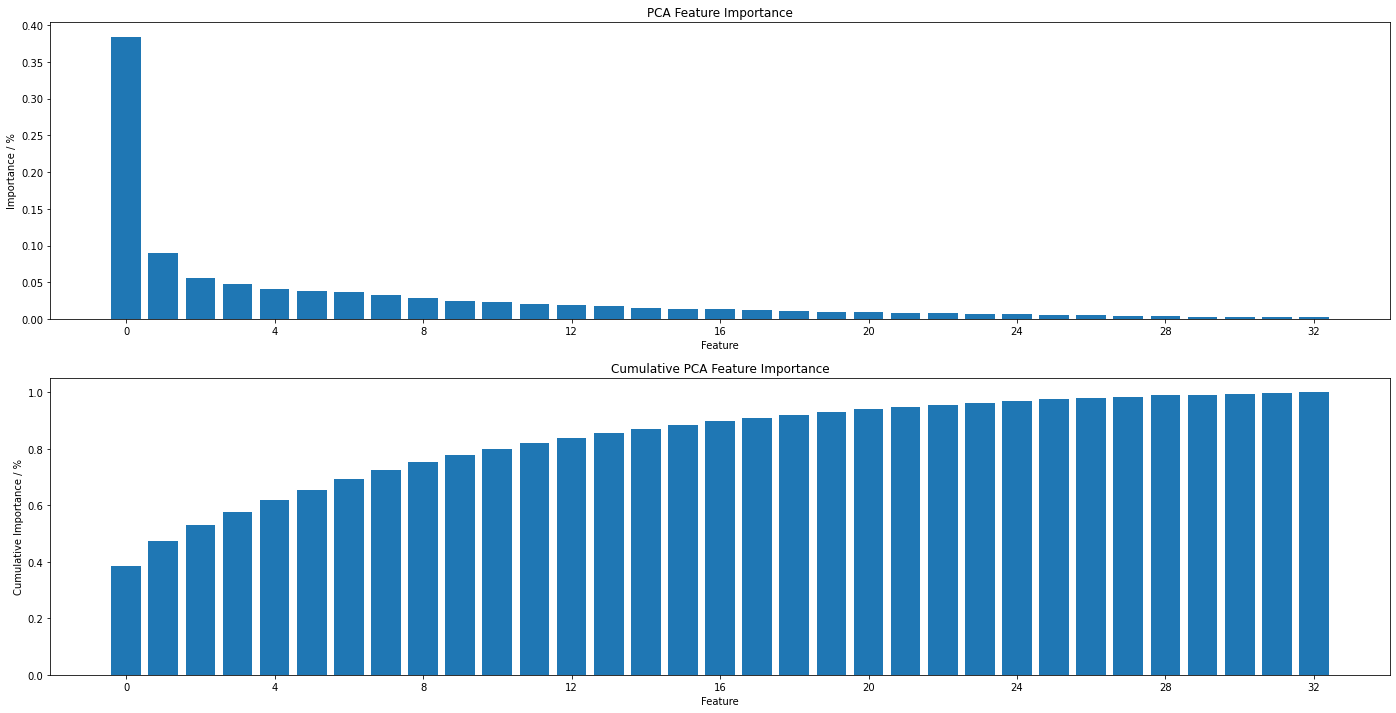

In [42]:
if __name__ == "__main__":
    fig, axs = plt.subplots(2, figsize=(24, 12))

    i=0
    axs[i].set_title("PCA Feature Importance")
    axs[i].set_ylabel("Importance / %")
    axs[i].set_xlabel("Feature")
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i].bar(range(pca.n_components), pca.explained_variance_ratio_)
    i += 1

    axs[i].set_title("Cumulative PCA Feature Importance")
    axs[i].set_ylabel("Cumulative Importance / %")
    axs[i].set_xlabel("Feature")
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i].bar(range(pca.n_components), np.cumsum(pca.explained_variance_ratio_))
    i += 1


In [43]:
def approximate_normal_params(arrays):
    return np.array(list(norm.fit(x) for x in arrays))

if __name__ == "__main__":
    pca_normal_params = approximate_normal_params(pca_ftrs.T)

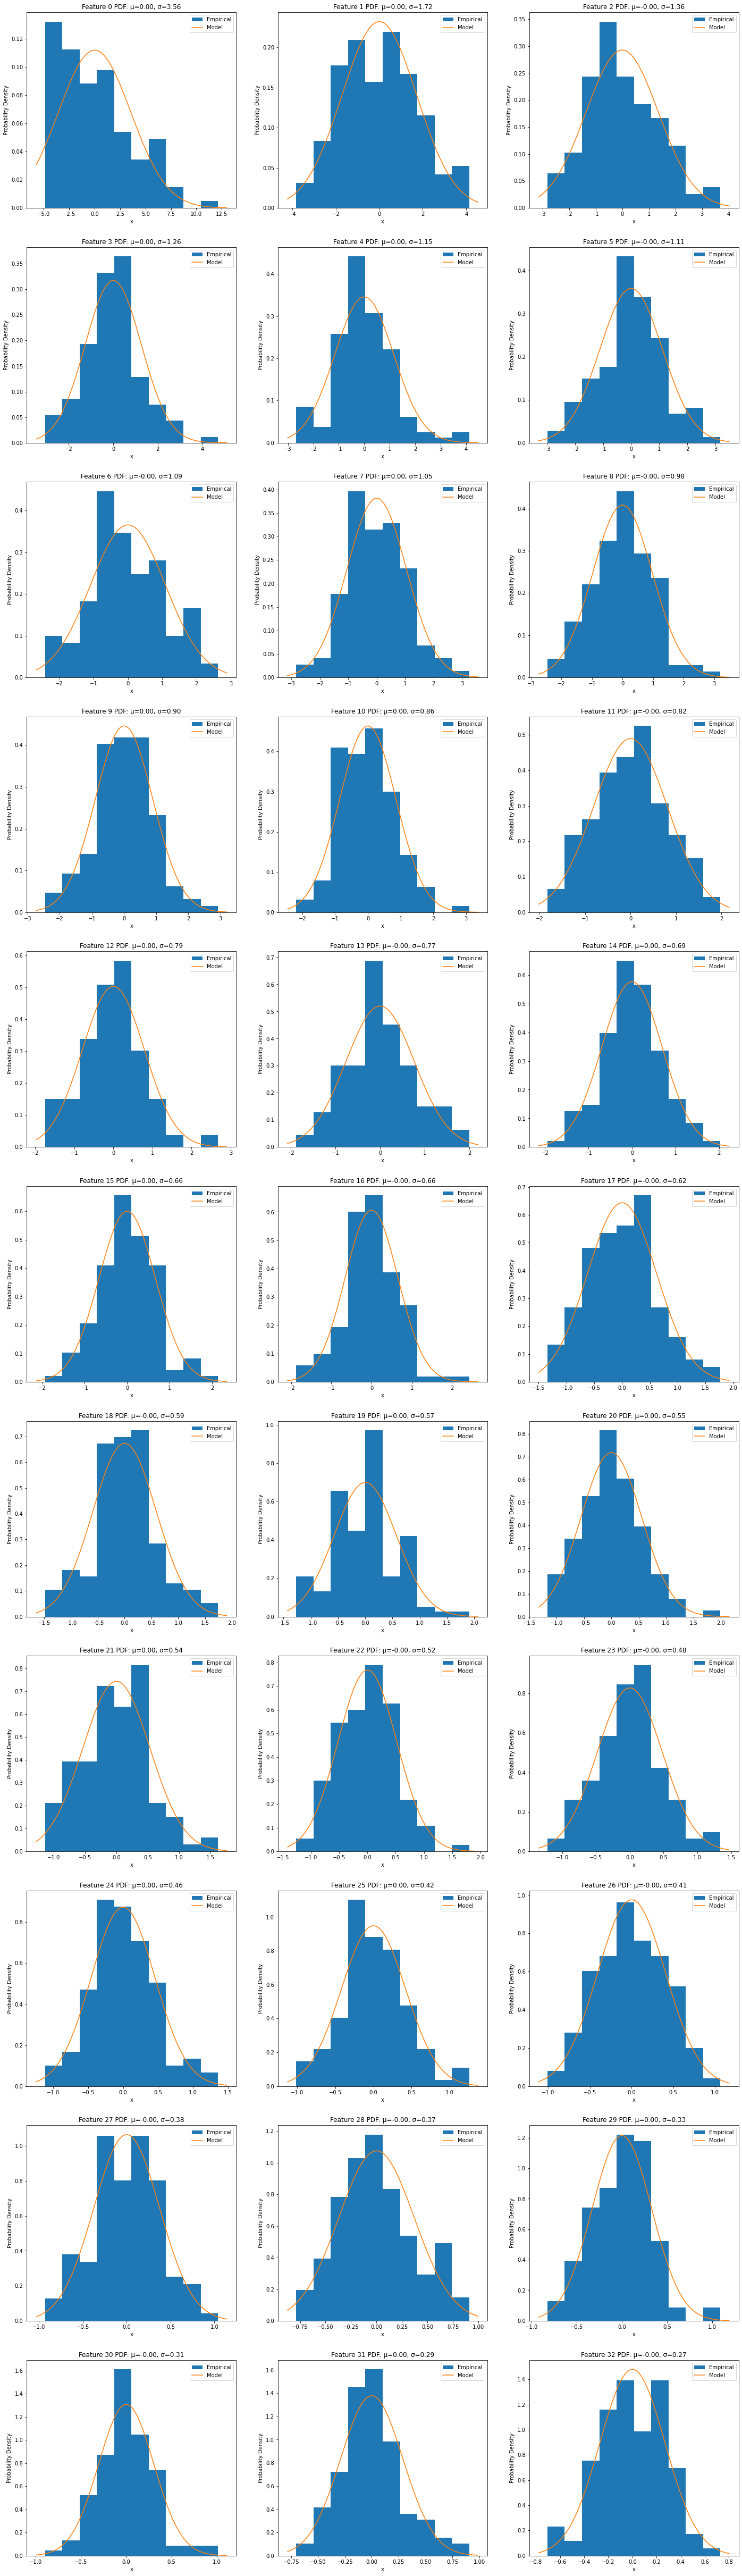

In [44]:
if __name__ == "__main__":
    rows, cols = tools.factor_squarely(pca_ftrs.shape[1])
    fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 8*rows))

    for y in range(rows):
        for x in range(cols):
            i = y * cols + x
            axs[y,x].set_title(f"Feature {i} PDF: μ={pca_normal_params[i,0]:.2f}, σ={pca_normal_params[i,1]:.2f}")
            axs[y,x].set_ylabel(f"Probability Density")
            axs[y,x].set_xlabel(f"x")
            axs[y,x].hist(pca_ftrs[:,i], label="Empirical", density=True)
            xmin, xmax = axs[y,x].get_xlim()
            x_ = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x_, *pca_normal_params[i])
            axs[y,x].plot(x_, p, label="Model")
            axs[y,x].legend()


In [45]:
def split_by_length(x, lengths):
    old_l = 0
    for l in lengths:
        yield x[:,old_l:old_l+l]
        old_l += l

def generate_synthetic_pca_ftrs(n, pca_normal_params):
    return np.stack(list(np.random.normal(*pca_normal_params[i], n) for i in range(len(pca_normal_params)))).T

def calculate_user_data_from_pca_ftrs(pca_ftrs, pca, normalizer):
    raw_ftrs = normalizer.inverse_transform(pca.inverse_transform(pca_ftrs))
    lengths = (10, 3, 20)
    b5, gender_age_income, mean_rt_per_cat = split_by_length(raw_ftrs, lengths)
    return b5, gender_age_income, mean_rt_per_cat
